In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import numpy as np

# Завантаження та підготовка даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Масштабування даних
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Додавання осі каналу для відповідності формату (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"Train data shape: {x_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")

# Побудова моделі
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(8, (3, 3), activation='relu'),  # Зменшено кількість фільтрів
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),  # Менше нейронів
    Dropout(0.5),  # Збільшено Dropout
    Dense(10, activation='softmax')
])

# Компіляція моделі
model.compile(
    optimizer=SGD(learning_rate=0.01),  # Простіший оптимізатор
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Навчання моделі
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,  # Менше епох
    batch_size=64,
    verbose=2
)

# Оцінка моделі
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Передбачення
y_pred = np.argmax(model.predict(x_test), axis=1)

# Звіт класифікації
print(classification_report(y_test, y_pred))


Train data shape: (60000, 28, 28, 1), Train labels shape: (60000,)
Test data shape: (10000, 28, 28, 1), Test labels shape: (10000,)
Epoch 1/20
938/938 - 7s - 8ms/step - accuracy: 0.6637 - loss: 1.0484 - val_accuracy: 0.9049 - val_loss: 0.3613
Epoch 2/20
938/938 - 6s - 6ms/step - accuracy: 0.8394 - loss: 0.5301 - val_accuracy: 0.9235 - val_loss: 0.2711
Epoch 3/20
938/938 - 10s - 11ms/step - accuracy: 0.8638 - loss: 0.4510 - val_accuracy: 0.9322 - val_loss: 0.2359
Epoch 4/20
938/938 - 6s - 6ms/step - accuracy: 0.8751 - loss: 0.4120 - val_accuracy: 0.9376 - val_loss: 0.2146
Epoch 5/20
938/938 - 10s - 11ms/step - accuracy: 0.8842 - loss: 0.3852 - val_accuracy: 0.9412 - val_loss: 0.1972
Epoch 6/20
938/938 - 6s - 6ms/step - accuracy: 0.8878 - loss: 0.3688 - val_accuracy: 0.9461 - val_loss: 0.1895
Epoch 7/20
938/938 - 10s - 11ms/step - accuracy: 0.8921 - loss: 0.3546 - val_accuracy: 0.9466 - val_loss: 0.1806
Epoch 8/20
938/938 - 10s - 11ms/step - accuracy: 0.8959 - loss: 0.3397 - val_accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


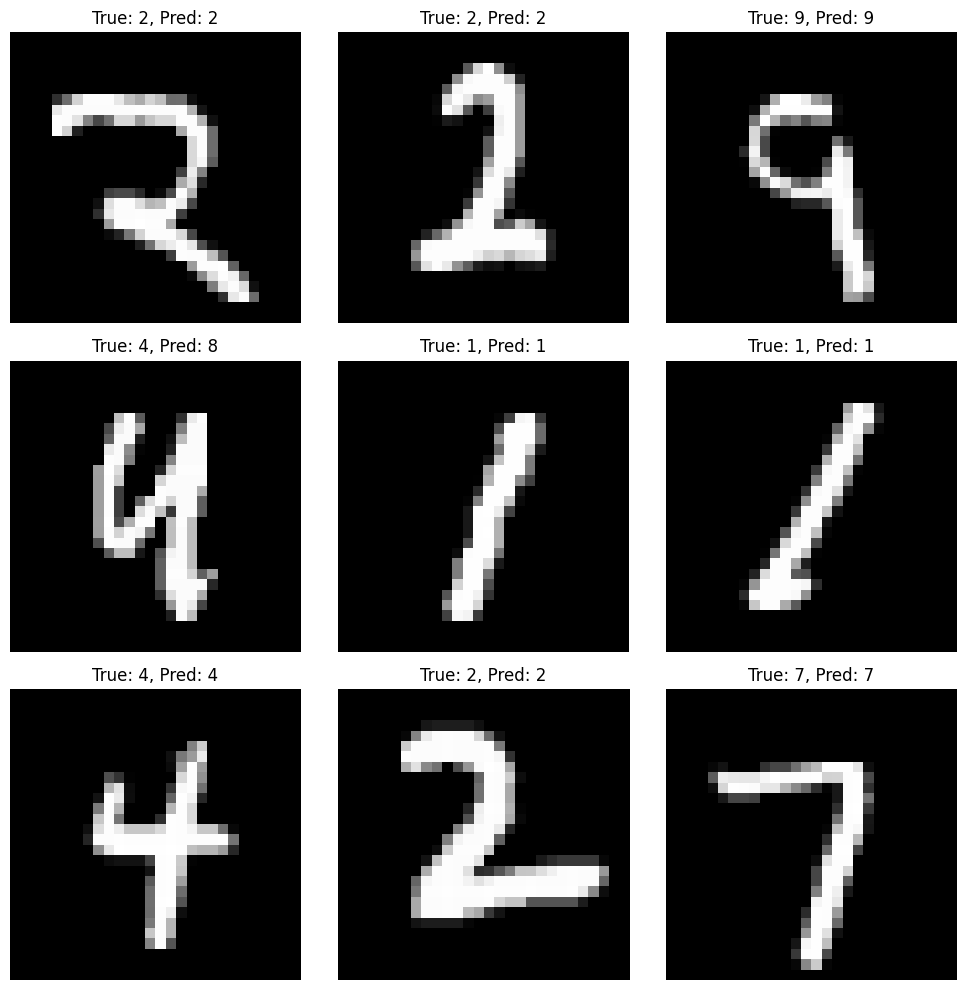

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Передбачення для тестових даних
y_pred_probs = model.predict(x_test)  # Ймовірності для кожного класу
y_pred = np.argmax(y_pred_probs, axis=1)  # Найбільш ймовірний клас

# Виведення кількох прикладів
num_examples = 9  # Кількість прикладів для відображення
indices = np.random.choice(len(x_test), num_examples, replace=False)  # Випадкові індекси

fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Побудова сітки 3x3
for i, ax in enumerate(axes.flat):
    idx = indices[i]
    ax.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    ax.axis('off')  # Вимкнення осей
plt.tight_layout()
plt.show()

In [ ]:
Точність на тестовому наборі склала 96.04%, що відповідає вимогам завдання.
Значення precision, recall і f1-score по класах вказують на високу ефективність моделі.
Різниця між accuracy на навчальних (91.92%) і тестових даних (96.04%) є прийнятною.
Це підтверджує, що додаткові Dropout-шари ефективно справляються з перенавчанням.
